In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai

In [3]:
from pathlib import Path
import pickle
from PIL import Image

import matplotlib.pyplot as plt

from fastai.vision import ImageDataBunch
from fastai.vision import LabelLists
from fastai.vision import get_transforms

In [4]:
import torch, fastai
torch.__version__, fastai.__version__

('1.1.0', '1.0.58')

In [5]:
cifar100_stats = (torch.tensor([0.5070751592371323, 0.48654887331495095, 0.4409178433670343]),
 torch.tensor([0.26733428587924035, 0.2564384629170881, 0.2761504713256853]))

In [6]:
path = Path('cifar100')
train_file = 'train'
test_file = 'test'

In [7]:
data = ImageDataBunch.from_folder(path,
                                  train=f'train_data',
                                  valid=f'valid_data',
                                  ds_tfms=get_transforms(),
                                  num_workers=10,
                                  bs=256,
                                 ).normalize(cifar100_stats)


CPU times: user 2.87 s, sys: 372 ms, total: 3.24 s
Wall time: 2.25 s


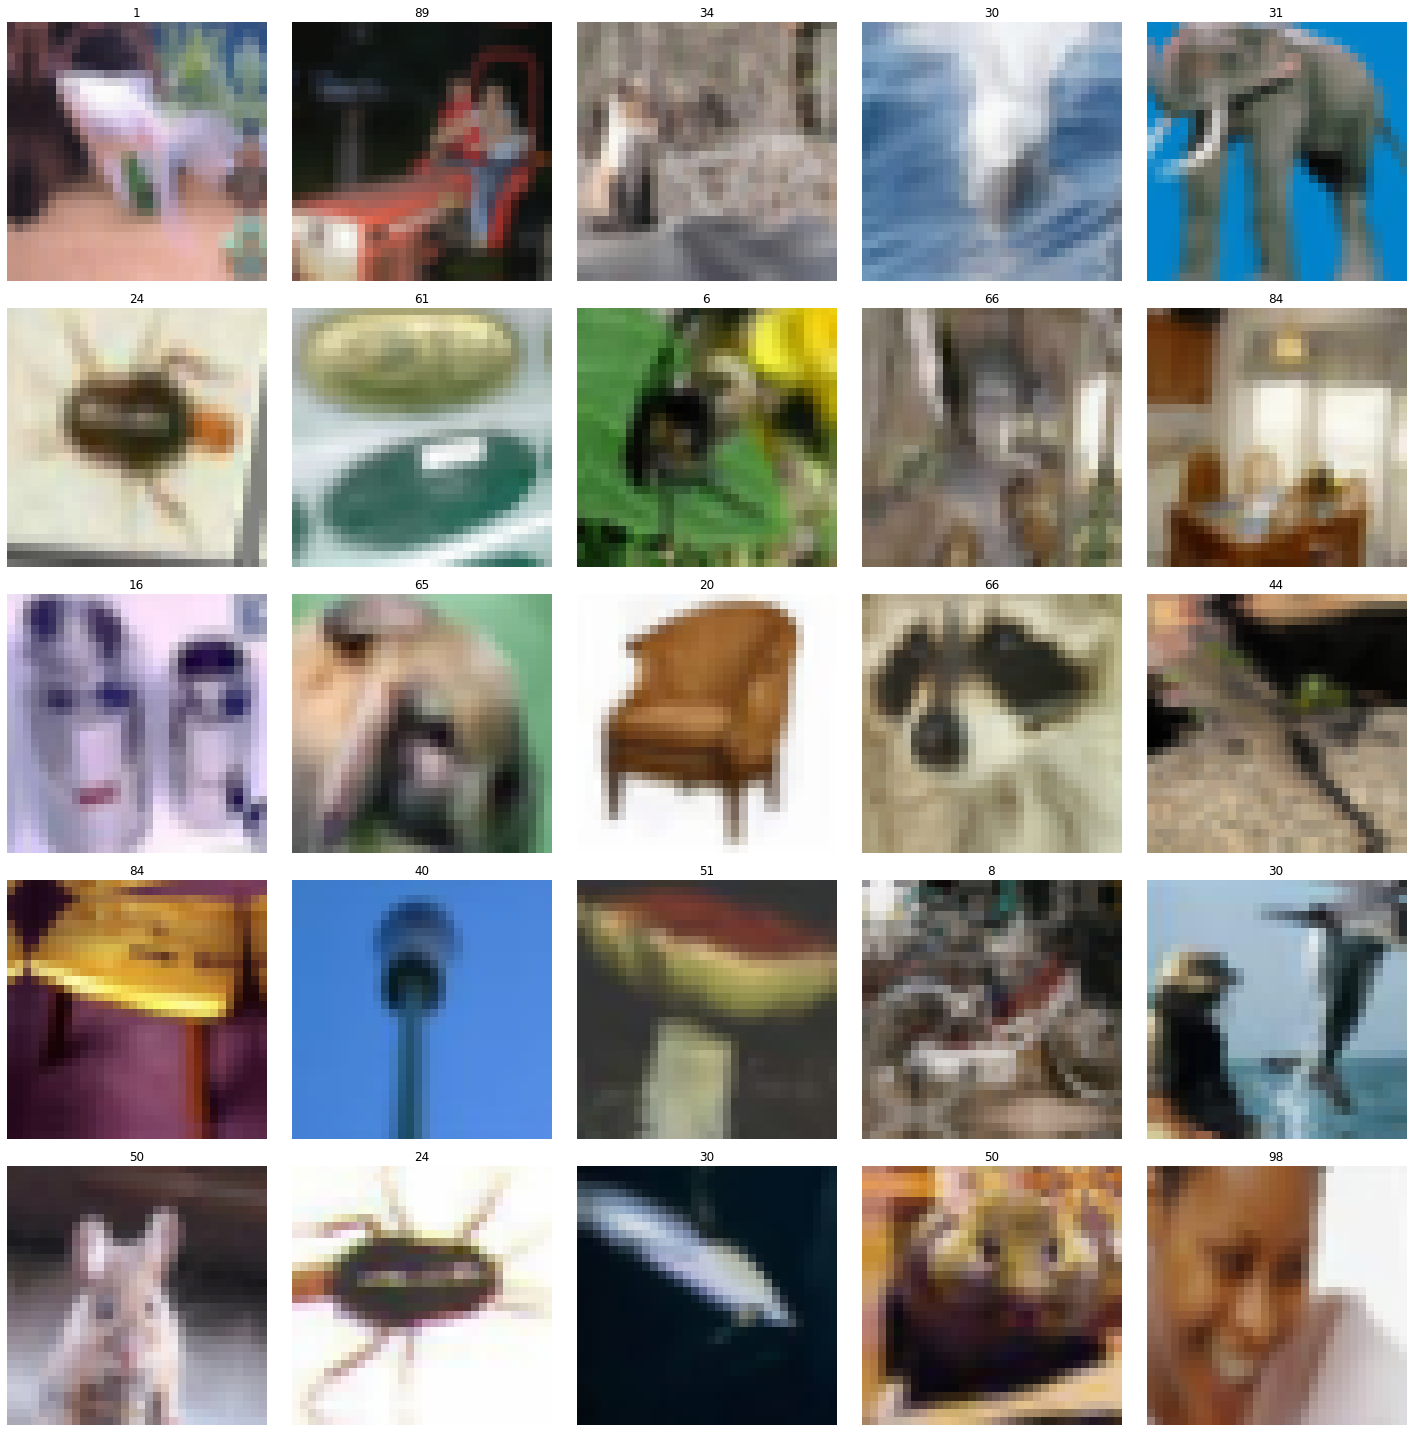

In [8]:
%%time
data.show_batch()

In [9]:
from torchvision import models
from fastai.vision import cnn_learner, accuracy, create_body
from fastai.callbacks import model_sizes, hook_outputs

In [10]:
from torch import nn
from torchsummary import summary
import numpy as np

In [11]:
# from drn import drn_d_24

In [12]:
# def get_hook_idxs(module):
#     "Get the indexes of the layers where the size of the activation changes."
#     sizes = model_sizes(module, size=(32, 32))
#     feature_szs = [size[-1] for size in sizes]
#     sfs_idxs = list(np.where(np.array(feature_szs[:-1]) != np.array(feature_szs[1:]))[0])
#     if feature_szs[0] != feature_szs[1]: sfs_idxs = [0] + sfs_idxs
#     return sfs_idxs

In [13]:
# class Mod(nn.Module):
#     def __init__(self, backbone_fn, num_classes=100, middle_size=64, **kwargs):
#         super().__init__()
#         self.backbone = create_body(backbone_fn, **kwargs)
#         self.sizes = model_sizes(self.backbone, size=(32, 32))
#         self.hook_idxs = get_hook_idxs(self.backbone)
#         self.hooks = hook_outputs([self.backbone[i] for i in self.hook_idxs])
#         self.convs = nn.ModuleList([nn.Sequential(nn.Conv2d(self.sizes[s][1], middle_size, kernel_size=3, padding=1),
#                                                   nn.BatchNorm2d(middle_size),
#                                                   nn.ReLU(inplace=True),
#                                                   nn.AdaptiveAvgPool2d(1)
#                                    ) for s in self.hook_idxs])
        
#         final_in = middle_size * len(self.hook_idxs) + self.sizes[-1][1]
#         self.final = nn.Conv2d(final_in, num_classes, kernel_size=1)
        
        
#     def forward(self, inp):
#         feats = [self.backbone(inp)]
#         for i, conv in enumerate(self.convs):
#             feats.append(conv(self.hooks[i].stored))
#         self.remove()
#         final_feats = torch.cat(feats, 1)        
#         return self.final(final_feats).squeeze()
        
#     def remove(self):
#         torch.cuda.empty_cache()
#         for hook in self.hooks:
#             del hook.stored

In [14]:
# a = model.hooks[0].stored

In [15]:
# learn.pred_batch()

In [16]:
# b = learn.model.hooks[0].stored

In [17]:
# (a - b).sum()

In [18]:
from fastai.vision.models import wrn_22, WideResNet

In [19]:
# model = create_body(wrn_22, cut=-1)

In [20]:
from fastai.basic_train import Learner

In [21]:
learn = Learner(data, WideResNet(num_groups=4, N=4, num_classes=100, k=8, drop_p=0.1), metrics=[accuracy]).mixup()

In [22]:
# learn = cnn_learner(data, drn_d_24, metrics=[accuracy], pretrained=False).mixup()

In [23]:
# for n, m in learn.model.named_parameters():
#     print(m.requires_grad)

In [24]:
# learn.summary()

In [25]:

# summary(learn.model, input_size=(3, 32, 32))

In [26]:
from fastai.callbacks import SaveModelCallback
from torch import nn
import torch.nn.functional as F

In [27]:
learn.fit_one_cycle(200, 5e-3, callbacks=SaveModelCallback(learn, name='wrn_mod'), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.986458,3.607584,0.137800,02:18
1,3.604578,3.233910,0.206100,02:18
2,3.335202,2.847516,0.276900,02:18
3,3.099043,2.594221,0.330900,02:18


Better model found at epoch 0 with valid_loss value: 3.607583522796631.
Better model found at epoch 1 with valid_loss value: 3.233909845352173.
Better model found at epoch 2 with valid_loss value: 2.8475162982940674.
Better model found at epoch 3 with valid_loss value: 2.5942211151123047.


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/divyansh/.conda/envs/torch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/divyansh/.conda/envs/torch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/divyansh/.conda/envs/torch/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/divyansh/.conda/envs/torch/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/divyansh/.conda/envs/torch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/divyansh/.conda/envs/torch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/divyansh/.conda/envs/torch/lib/python3

KeyboardInterrupt: 


####  Focal Loss

In [35]:
## code from http://www.hawia.xyz/2019/01/12/Losses%20of%20Pytorch%20and%20Focal%20Loss/

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target, reduction):
        """
        input: [N, C], float32
        target: [N, ], int64
        """
        logpt = F.log_softmax(input, dim=1)
        pt = torch.exp(logpt)
        logpt = (1-pt) ** self.gamma * logpt
        loss = F.nll_loss(logpt, target, self.weight, reduction)
        return loss

In [36]:
# set focal loss
focal_loss = FocalLoss()
learn.loss_func = focal_loss

In [37]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 10.91 GiB total capacity; 6.00 GiB already allocated; 145.00 MiB free; 11.07 MiB cached)

In [41]:
# class RemoveHookCallback

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learn.fit_one_cycle(200, 5e-3, callbacks=SaveModelCallback(learn, name='drn_d_24'), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,2.403046,1.481130,0.525600,00:25
1,2.218378,1.439253,0.535600,00:26
2,2.093489,1.425676,0.544600,00:26
3,2.015167,1.399289,0.550200,00:26
4,1.938601,1.394015,0.555200,00:26
5,1.904228,1.382258,0.560000,00:26
6,1.874315,1.401401,0.562600,00:26
7,1.842265,1.379506,0.563300,00:25
8,1.819051,1.391844,0.567000,00:26
9,1.800400,1.379543,0.565500,00:26


Better model found at epoch 0 with valid_loss value: 1.4811296463012695.
Better model found at epoch 1 with valid_loss value: 1.4392529726028442.
Better model found at epoch 2 with valid_loss value: 1.4256762266159058.
Better model found at epoch 3 with valid_loss value: 1.3992887735366821.
Better model found at epoch 4 with valid_loss value: 1.3940153121948242.
Better model found at epoch 5 with valid_loss value: 1.3822580575942993.
Better model found at epoch 7 with valid_loss value: 1.3795063495635986.
Better model found at epoch 10 with valid_loss value: 1.3634651899337769.


In [ ]:
# learn.save('DRNET22-200')

/home/divyansh/.conda/envs/torch/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


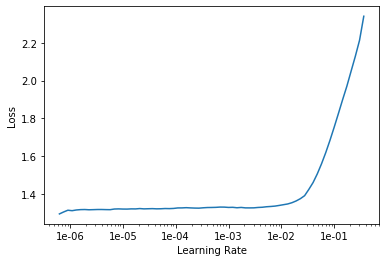

In [23]:
learn.lr_find()
learn.recorder.plot()

In [29]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learn.fit_one_cycle(200, 1e-3, callbacks=SaveModelCallback(learn, name='DRNET22'), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.334570,1.139792,0.672500,00:20
1,1.325988,1.138140,0.672600,00:20
2,1.322971,1.140874,0.673700,00:20
3,1.324074,1.142497,0.671800,00:20
4,1.325206,1.141055,0.672800,00:19
5,1.316245,1.138631,0.673500,00:20
6,1.318240,1.142995,0.672700,00:19
7,1.311314,1.141441,0.672700,00:20
8,1.313173,1.142094,0.673700,00:20
9,1.314234,1.135544,0.674100,00:20


Better model found at epoch 0 with valid_loss value: 1.13979172706604.
Better model found at epoch 1 with valid_loss value: 1.1381398439407349.
Better model found at epoch 9 with valid_loss value: 1.1355443000793457.
Better model found at epoch 17 with valid_loss value: 1.134138584136963.


In [32]:
learn.load('resnet_18_focal_loss2');

In [33]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learn.fit_one_cycle(200, 1e-3, callbacks=SaveModelCallback(learn, name='resnet_18_focal_loss2'), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.517546,1.429511,0.669600,00:17
1,1.507275,1.413386,0.671500,00:17
2,1.495315,1.395798,0.671300,00:17
3,1.485747,1.379543,0.673000,00:18
4,1.474151,1.364876,0.672800,00:17
5,1.460931,1.354243,0.673100,00:17
6,1.449556,1.343997,0.672800,00:18
7,1.440124,1.336930,0.673000,00:18
8,1.432185,1.335551,0.674200,00:18
9,1.423800,1.333044,0.674300,00:17


Better model found at epoch 0 with valid_loss value: 1.4295111894607544.
Better model found at epoch 1 with valid_loss value: 1.4133862257003784.
Better model found at epoch 2 with valid_loss value: 1.3957982063293457.
Better model found at epoch 3 with valid_loss value: 1.3795428276062012.
Better model found at epoch 4 with valid_loss value: 1.3648756742477417.
Better model found at epoch 5 with valid_loss value: 1.3542433977127075.
Better model found at epoch 6 with valid_loss value: 1.3439967632293701.
Better model found at epoch 7 with valid_loss value: 1.3369300365447998.
Better model found at epoch 8 with valid_loss value: 1.3355505466461182.
Better model found at epoch 9 with valid_loss value: 1.3330435752868652.
Better model found at epoch 10 with valid_loss value: 1.3328150510787964.
Better model found at epoch 112 with valid_loss value: 1.3323487043380737.
Better model found at epoch 127 with valid_loss value: 1.3284796476364136.
Better model found at epoch 128 with valid_los

In [35]:
from fastai.callbacks import ReduceLROnPlateauCallback

In [41]:
cb = ReduceLROnPlateauCallback(learn, patience=5, factor=0.5)

In [43]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learn.fit_one_cycle(200, 1e-3, callbacks=SaveModelCallback(learn, name='resnet_18_focal_loss2'), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.712098,2.820930,0.402000,00:17
1,1.692564,2.119849,0.521300,00:17
2,1.675956,1.973245,0.549700,00:17
3,1.653836,1.911193,0.561600,00:17
4,1.629140,1.864846,0.570300,00:17
5,1.599716,1.826674,0.577200,00:17
6,1.572340,1.791006,0.584600,00:17
7,1.543894,1.754567,0.590800,00:17
8,1.517390,1.720562,0.598500,00:18
9,1.486276,1.685708,0.608100,00:17


Better model found at epoch 0 with valid_loss value: 2.820929527282715.
Better model found at epoch 1 with valid_loss value: 2.11984920501709.
Better model found at epoch 2 with valid_loss value: 1.9732446670532227.
Better model found at epoch 3 with valid_loss value: 1.911192774772644.
Better model found at epoch 4 with valid_loss value: 1.8648464679718018.
Better model found at epoch 5 with valid_loss value: 1.826673984527588.
Better model found at epoch 6 with valid_loss value: 1.7910062074661255.
Better model found at epoch 7 with valid_loss value: 1.75456702709198.
Better model found at epoch 8 with valid_loss value: 1.72056245803833.
Better model found at epoch 9 with valid_loss value: 1.6857081651687622.
Better model found at epoch 10 with valid_loss value: 1.651167631149292.
Better model found at epoch 11 with valid_loss value: 1.6211827993392944.
Better model found at epoch 12 with valid_loss value: 1.5911500453948975.
Better model found at epoch 13 with valid_loss value: 1.56

In [44]:
learn.save('focal2')

In [27]:
from fastai.vision import ClassificationInterpretation

In [28]:
learn.load('wrn')

Learner(data=ImageDataBunch;

Train: LabelList (50000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
45,45,45,45,45
Path: cifar100;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
45,45,45,45,45
Path: cifar100;

Test: None, model=WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BasicBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (short

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

In [34]:
interp.pred_class

tensor([40, 40, 40,  ..., 57, 57, 57])

In [38]:
(interp.y_true == interp.pred_class).float().mean()

tensor(0.7248)

In [32]:
interp.confusion_matrix()

array([[94,  0,  0,  0, ...,  0,  0,  0,  0],
       [ 0, 92,  0,  0, ...,  0,  0,  0,  0],
       [ 7,  1, 40,  0, ...,  0,  0,  0,  1],
       [ 0,  0,  0, 26, ...,  0,  0, 10,  0],
       ...,
       [ 0,  0,  0,  0, ..., 39,  0,  0,  0],
       [ 0,  0,  0,  0, ...,  0, 73,  0,  0],
       [ 0,  0,  0,  2, ...,  0,  0, 54,  0],
       [ 1,  0,  0,  0, ...,  0,  0,  0, 78]])

In [57]:
learn.fit_one_cycle(220, 6e-3, callbacks=SaveModelCallback(learn, name='resnet18_96__'), start_epoch=180, wd=0.1)

Model resnet18_96___179 not found.


epoch,train_loss,valid_loss,error_rate,accuracy,time
180,1.109538,1.212131,0.291400,0.708600,10:31
181,1.123748,1.206399,0.291200,0.708800,10:27
182,1.123520,1.196451,0.286100,0.713900,10:33
183,1.123557,1.203960,0.287800,0.712200,10:37
184,1.120785,1.189389,0.283300,0.716700,10:43
185,1.120251,1.191710,0.284500,0.715500,10:46
186,1.121703,1.191914,0.283900,0.716100,11:08
187,1.112743,1.173061,0.282100,0.717900,10:50
188,1.110120,1.180446,0.283800,0.716200,10:45
189,1.114519,1.180402,0.286400,0.713600,10:50


Better model found at epoch 180 with valid_loss value: 1.2121307849884033.
Better model found at epoch 181 with valid_loss value: 1.2063989639282227.
Better model found at epoch 182 with valid_loss value: 1.1964513063430786.
Better model found at epoch 184 with valid_loss value: 1.189388632774353.
Better model found at epoch 187 with valid_loss value: 1.173061490058899.
Better model found at epoch 190 with valid_loss value: 1.1564682722091675.


KeyboardInterrupt: 